
---

# **🔍 04 - Model Testing: Traditional NLP Pipeline**

## **📑 Table of Contents**
1.  [🎯 Objectives](#-objectives)
2.  [⚙️ Setup & Imports](#-setup--imports)
3.  [📥 Load Aggressively Cleaned Data](#-load-aggressively-cleaned-data)
4.  [🌿 Text Processing: Stemming vs Lemmatization](#-text-processing-stemming-vs-lemmatization)
5.  [📊 TF-IDF Vectorization](#-tf-idf-vectorization)
6.  [🤖 Model Training](#-model-training)
7.  [📊 Comprehensive Model Evaluation](#-comprehensive-model-evaluation)
8.  [📈 Advanced Visualizations](#-advanced-visualizations)
9.  [🏆 Best Model Selection](#-best-model-selection)
10. [💾 Save Results](#-save-results)

---

## **🎯 Objectives**
- Compare stemming vs lemmatization techniques
- Test traditional NLP pipeline with TF-IDF
- Evaluate multiple classification models
- Select the best text processing strategy



---

## **⚙️ 1. Setup & Imports**


In [ ]:

# Add project root to path
import sys
import os
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

# Model training
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Enhanced evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, roc_curve, confusion_matrix, classification_report,
                            precision_recall_curve, auc)

# NLP libraries
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Model persistence
import joblib

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

print("✅ All libraries imported successfully!")
%matplotlib inline
plt.style.use('default')


✅ All libraries imported successfully!


[nltk_data] Downloading package punkt to /Users/guillermo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/guillermo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/guillermo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



---

## **📥 2. Load Aggressively Cleaned Data**


In [3]:

print("📁 Loading aggressively cleaned data...")
df = pd.read_csv('../dataset/01_interim/cleaned_data_aggressive.csv')
print(f"📊 Dataset shape: {df.shape}")
print(f"🎯 Label distribution:\n{df['label'].value_counts()}")

# Prepare data
X = df['clean_title']
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📚 Training set: {len(X_train)} samples")
print(f"🧪 Test set: {len(X_test)} samples")


📁 Loading aggressively cleaned data...
📊 Dataset shape: (39942, 6)
🎯 Label distribution:
label
1    19999
0    19943
Name: count, dtype: int64
📚 Training set: 31953 samples
🧪 Test set: 7989 samples



---

## **🌿 3. Text Processing: Stemming vs Lemmatization**


In [4]:

print("🌿 Preparing text processing functions...")

# Initialize processors
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def stem_text(text):
    """Apply stemming to text"""
    words = word_tokenize(str(text))
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join([stemmer.stem(word) for word in words])

def lemmatize_text(text):
    """Apply lemmatization to text"""
    words = word_tokenize(str(text))
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

# Test the functions
test_text = "running runners ran easily easier quickly"
print("🧪 Test Text:", test_text)
print("✂️ Stemmed:", stem_text(test_text))
print("🌿 Lemmatized:", lemmatize_text(test_text))

# Apply processing to datasets
print("\n🔄 Applying text processing strategies...")

processing_strategies = {
    'original': X_train,
    'stemmed': X_train.apply(stem_text),
    'lemmatized': X_train.apply(lemmatize_text)
}

print("✅ Text processing completed!")


🌿 Preparing text processing functions...
🧪 Test Text: running runners ran easily easier quickly
✂️ Stemmed: run runner ran easili easier quickli
🌿 Lemmatized: running runner ran easily easier quickly

🔄 Applying text processing strategies...
✅ Text processing completed!



---

## **📊 4. TF-IDF Vectorization**


In [6]:
print("📊 Applying TF-IDF vectorization...")

# First, ensure we handle any NaN values
print("   Checking for and handling NaN values...")
for strategy, text_data in processing_strategies.items():
    # Check for NaN values
    nan_count = text_data.isnull().sum()
    if nan_count > 0:
        print(f"      Found {nan_count} NaN values in {strategy} strategy - replacing with empty strings")
        processing_strategies[strategy] = text_data.fillna('')

vectorizers = {}
X_processed = {}

for strategy, text_data in processing_strategies.items():
    print(f"   Processing: {strategy}")
    
    # Double-check for any remaining NaN values
    text_data = text_data.fillna('')
    
    # Initialize and fit TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1, 2),  # Include bigrams
        min_df=2,            # Ignore very rare words
        max_df=0.95,         # Ignore very common words
        dtype=np.float32     # Use float32 to save memory
    )
    
    try:
        X_processed[strategy] = vectorizer.fit_transform(text_data)
        vectorizers[strategy] = vectorizer
        
        print(f"      Vocabulary size: {len(vectorizer.get_feature_names_out())}")
        print(f"      Matrix shape: {X_processed[strategy].shape}")
    except Exception as e:
        print(f"      Error processing {strategy}: {e}")
        # Debug: check what's in the text data that might be causing issues
        print(f"      Sample of text data: {text_data.head(3).tolist()}")

# Also process test data - with NaN handling
X_test_processed = {}
for strategy in processing_strategies.keys():
    if strategy == 'original':
        test_data = X_test.fillna('')  # Handle NaN values
    elif strategy == 'stemmed':
        test_data = X_test.apply(stem_text).fillna('')  # Handle NaN values
    else:
        test_data = X_test.apply(lemmatize_text).fillna('')  # Handle NaN values
    
    try:
        X_test_processed[strategy] = vectorizers[strategy].transform(test_data)
    except Exception as e:
        print(f"Error transforming test data for {strategy}: {e}")

print("✅ TF-IDF vectorization completed!")

📊 Applying TF-IDF vectorization...
   Checking for and handling NaN values...
      Found 5 NaN values in original strategy - replacing with empty strings
   Processing: original
      Vocabulary size: 5000
      Matrix shape: (31953, 5000)
   Processing: stemmed
      Vocabulary size: 5000
      Matrix shape: (31953, 5000)
   Processing: lemmatized
      Vocabulary size: 5000
      Matrix shape: (31953, 5000)
✅ TF-IDF vectorization completed!


In [7]:

# print("📊 Applying TF-IDF vectorization...")

# vectorizers = {}
# X_processed = {}

# for strategy, text_data in processing_strategies.items():
#     print(f"   Processing: {strategy}")
    
#     # Initialize and fit TF-IDF vectorizer
#     vectorizer = TfidfVectorizer(
#         max_features=5000,
#         stop_words='english',
#         ngram_range=(1, 2),  # Include bigrams
#         min_df=2,            # Ignore very rare words
#         max_df=0.95          # Ignore very common words
#     )
    
#     X_processed[strategy] = vectorizer.fit_transform(text_data)
#     vectorizers[strategy] = vectorizer
    
#     print(f"      Vocabulary size: {len(vectorizer.get_feature_names_out())}")
#     print(f"      Matrix shape: {X_processed[strategy].shape}")

# # Also process test data
# X_test_processed = {}
# for strategy in processing_strategies.keys():
#     if strategy == 'original':
#         test_data = X_test
#     elif strategy == 'stemmed':
#         test_data = X_test.apply(stem_text)
#     else:
#         test_data = X_test.apply(lemmatize_text)
    
#     X_test_processed[strategy] = vectorizers[strategy].transform(test_data)

# print("✅ TF-IDF vectorization completed!")


---

## **🤖 5. Model Training**


In [8]:
print("🤖 Initializing models...")
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'Naive Bayes': MultinomialNB()
}

# Store all results
all_results = {}
all_predictions = {}

print("🚀 Training models across all processing strategies...")
for strategy in processing_strategies.keys():
    print(f"\n📊 Strategy: {strategy.upper()}")
    print("=" * 40)
    
    strategy_results = {}
    strategy_predictions = {}
    
    for name, model in models.items():
        print(f"   Training {name}...")
        
        # Clone model for each strategy
        model_instance = model.__class__(**model.get_params())
        model_instance.fit(X_processed[strategy], y_train)
        
        # Store results
        strategy_results[name] = model_instance
        strategy_predictions[name] = {
            'model': model_instance,
            'X_test': X_test_processed[strategy]
        }
    
    all_results[strategy] = strategy_results
    all_predictions[strategy] = strategy_predictions

print("✅ All models trained successfully!")


🤖 Initializing models...
🚀 Training models across all processing strategies...

📊 Strategy: ORIGINAL
   Training Logistic Regression...
   Training Random Forest...
   Training SVM...
   Training Naive Bayes...

📊 Strategy: STEMMED
   Training Logistic Regression...
   Training Random Forest...
   Training SVM...
   Training Naive Bayes...

📊 Strategy: LEMMATIZED
   Training Logistic Regression...
   Training Random Forest...
   Training SVM...
   Training Naive Bayes...
✅ All models trained successfully!



---

## **📊 6. Comprehensive Model Evaluation**


In [ ]:

def comprehensive_evaluation(model, X_test, y_test, model_name="Model"):
    """Perform comprehensive evaluation with multiple metrics"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
    }
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    else:
        metrics['roc_auc'] = None
    
    return metrics, y_pred, y_pred_proba

print("📊 Evaluating all models comprehensively...")
evaluation_results = {}

for strategy, models_dict in all_predictions.items():
    print(f"\n🔍 Evaluating strategy: {strategy.upper()}")
    print("=" * 50)
    
    strategy_results = {}
    
    for name, data in models_dict.items():
        metrics, y_pred, y_pred_proba = comprehensive_evaluation(
            data['model'], data['X_test'], y_test, name
        )
        
        strategy_results[name] = metrics
        print(f"   {name:20} | Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1']:.4f}")
    
    evaluation_results[strategy] = strategy_results

print("✅ Comprehensive evaluation completed!")



📊 Evaluating all models comprehensively...

🔍 Evaluating strategy: ORIGINAL
   Logistic Regression  | Accuracy: 0.9439 | F1: 0.9448
   Random Forest        | Accuracy: 0.9337 | F1: 0.9341
   SVM                  | Accuracy: 0.9496 | F1: 0.9502
   Naive Bayes          | Accuracy: 0.9330 | F1: 0.9326

🔍 Evaluating strategy: STEMMED
   Logistic Regression  | Accuracy: 0.9444 | F1: 0.9453
   Random Forest        | Accuracy: 0.9307 | F1: 0.9311
   SVM                  | Accuracy: 0.9464 | F1: 0.9471
   Naive Bayes          | Accuracy: 0.9310 | F1: 0.9307

🔍 Evaluating strategy: LEMMATIZED
   Logistic Regression  | Accuracy: 0.9425 | F1: 0.9434
   Random Forest        | Accuracy: 0.9278 | F1: 0.9284
   SVM                  | Accuracy: 0.9477 | F1: 0.9484
   Naive Bayes          | Accuracy: 0.9300 | F1: 0.9296
✅ Comprehensive evaluation completed!



---

## **📈 7. Advanced Visualizations**


🎨 Generating advanced visualizations...


/var/folders/tx/45hhw1yn48jfdqn2hmnhbhvw0000gn/T/ipykernel_90391/2525767311.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/datasci_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


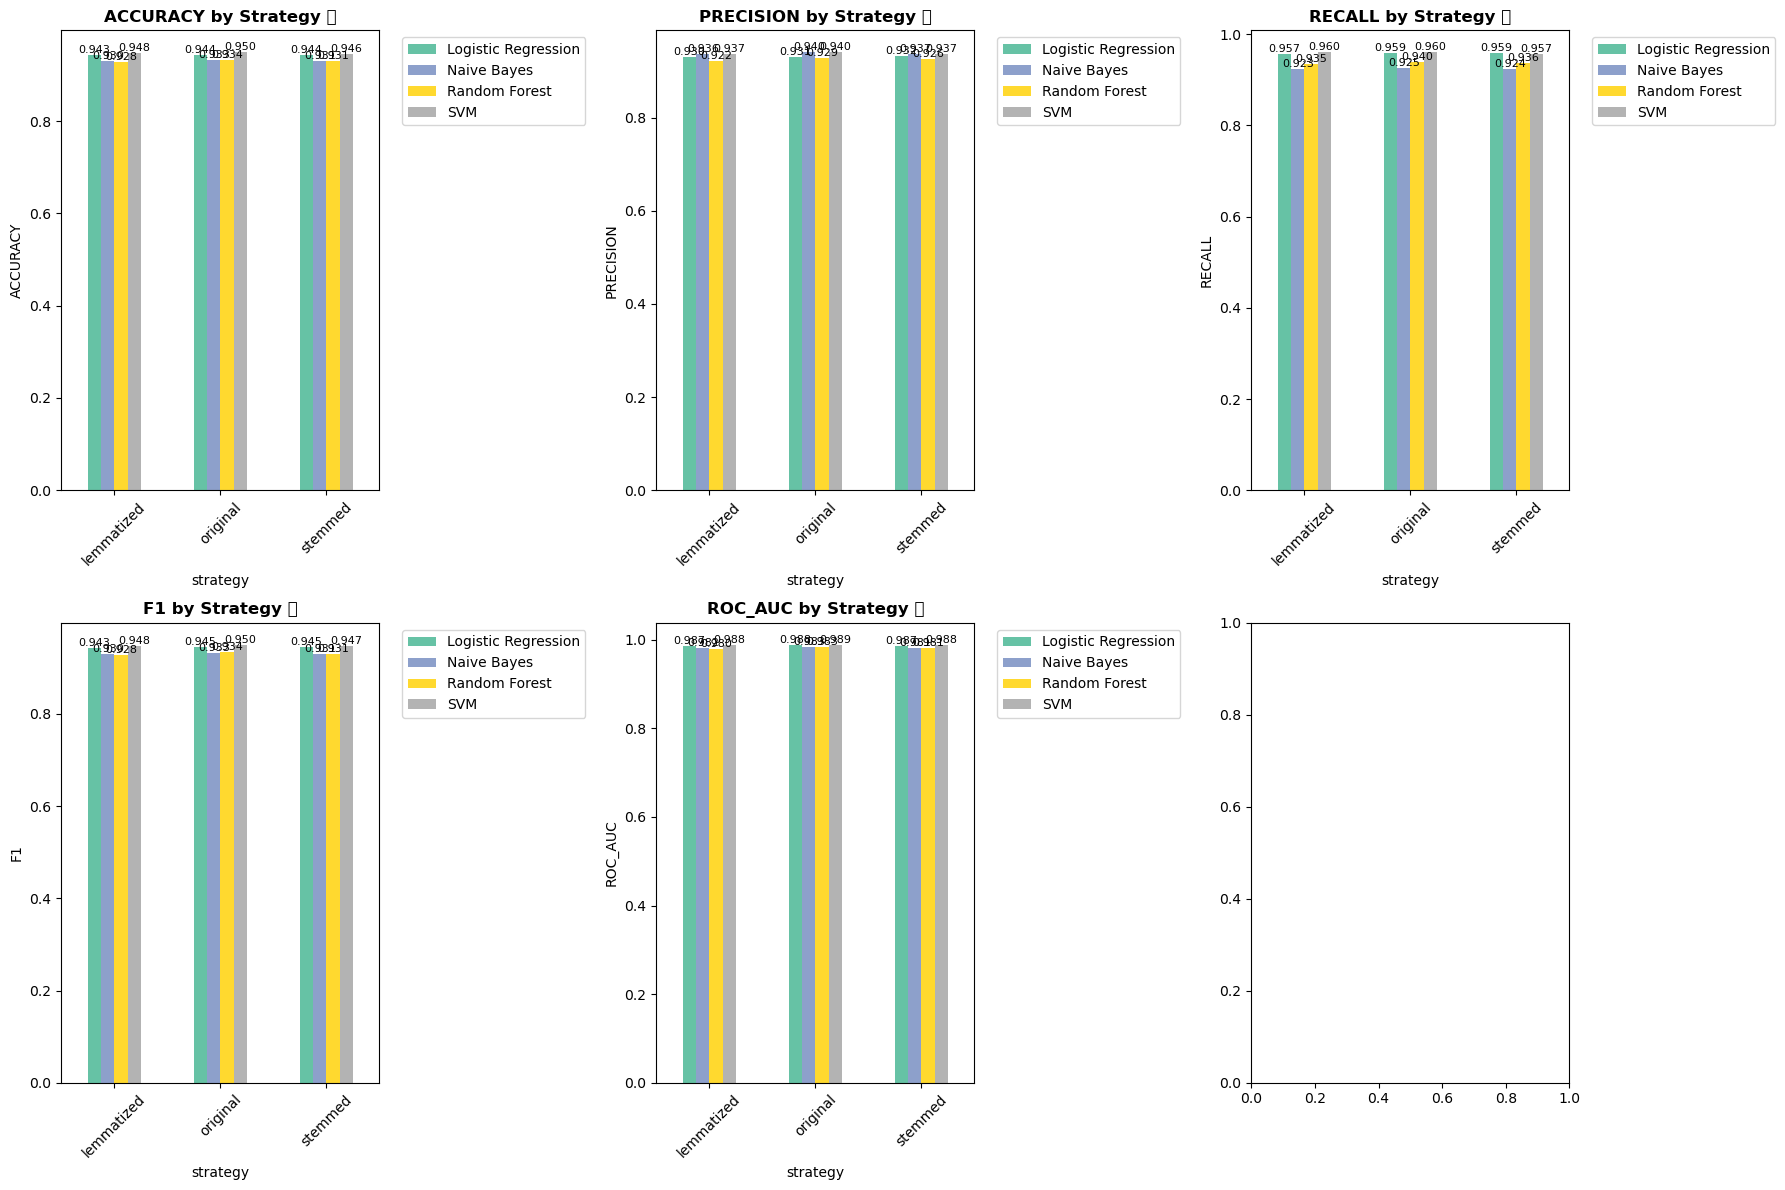

🏆 Best Model for Each Strategy:
ORIGINAL     | SVM                  | Accuracy: 0.9496
STEMMED      | SVM                  | Accuracy: 0.9464
LEMMATIZED   | SVM                  | Accuracy: 0.9477

🎯 Best Overall: SVM with original strategy


/opt/anaconda3/envs/datasci_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


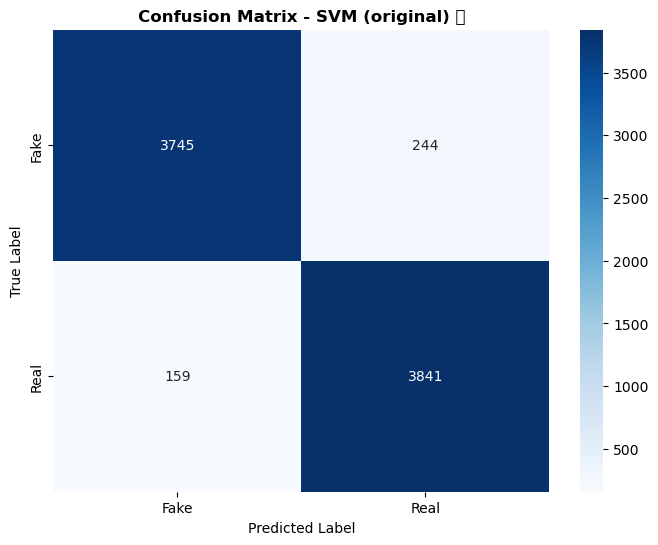

In [10]:

 
print("🎨 Generating advanced visualizations...")

# Convert results to DataFrame for easier plotting
results_list = []
for strategy, models in evaluation_results.items():
    for model_name, metrics in models.items():
        results_list.append({
            'strategy': strategy,
            'model': model_name,
            **metrics
        })

results_df = pd.DataFrame(results_list)

# 1. Comparative Metrics by Strategy
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for i, metric in enumerate(metrics_list):
    ax = axes[i//3, i%3]
    
    # Pivot table for easy plotting
    pivot_data = results_df.pivot_table(
        values=metric, index='strategy', columns='model', aggfunc='first'
    )
    
    pivot_data.plot(kind='bar', ax=ax, colormap='Set2')
    ax.set_title(f'{metric.upper()} by Strategy 📈', fontweight='bold')
    ax.set_ylabel(metric.upper())
    ax.tick_params(axis='x', rotation=45)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=8)

plt.tight_layout()
plt.show()

# 2. Best Model for Each Strategy
print("🏆 Best Model for Each Strategy:")
print("=" * 50)

for strategy in evaluation_results.keys():
    strategy_df = results_df[results_df['strategy'] == strategy]
    best_model = strategy_df.loc[strategy_df['accuracy'].idxmax()]
    print(f"{strategy.upper():12} | {best_model['model']:20} | Accuracy: {best_model['accuracy']:.4f}")

# 3. Confusion Matrix for Best Overall Model
best_overall = results_df.loc[results_df['accuracy'].idxmax()]
best_strategy = best_overall['strategy']
best_model_name = best_overall['model']

print(f"\n🎯 Best Overall: {best_model_name} with {best_strategy} strategy")
best_model_data = all_predictions[best_strategy][best_model_name]

# Plot confusion matrix
y_pred = best_model_data['model'].predict(best_model_data['X_test'])
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title(f'Confusion Matrix - {best_model_name} ({best_strategy}) 🎯', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## **🪵 8. Log experiment results**

In [11]:
# Cell: Log experiment results
print("📊 Logging experiment results...")

from src.experiment_tracker import log_experiment

# Log results for each strategy and model combination
for strategy in processing_strategies.keys():
    for model_name, model_data in all_results[strategy].items():
        # Get predictions for metrics
        X_test_processed = vectorizers[strategy].transform(
            X_test.apply(
                lambda x: stem_text(x) if strategy == 'stemmed' else 
                         lemmatize_text(x) if strategy == 'lemmatized' else x
            ).fillna('')
        )
        
        y_pred = model_data.predict(X_test_processed)
        y_pred_proba = model_data.predict_proba(X_test_processed)[:, 1] if hasattr(model_data, "predict_proba") else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        
        # Log experiment
        experiment_data = {
            'experiment_type': 'traditional_nlp',
            'model_name': model_name,
            'preprocessing': strategy,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'dataset': 'fake_news',
            'notes': f'TF-IDF with {strategy} processing'
        }
        
        log_experiment(experiment_data)

print("✅ All experiments logged!")

📊 Logging experiment results...
✅ Experiment logged: tr_lr_20250902_231836
✅ Experiment logged: tr_rf_20250902_231837
✅ Experiment logged: tr_s_20250902_231841
✅ Experiment logged: tr_nb_20250902_231841
✅ Experiment logged: tr_lr_20250902_231842
✅ Experiment logged: tr_rf_20250902_231844
✅ Experiment logged: tr_s_20250902_231849
✅ Experiment logged: tr_nb_20250902_231850
✅ Experiment logged: tr_lr_20250902_231850
✅ Experiment logged: tr_rf_20250902_231851
✅ Experiment logged: tr_s_20250902_231856
✅ Experiment logged: tr_nb_20250902_231856
✅ All experiments logged!


-----
# Draft


---

### 📓 **Notebook: `04_Model_Testing_Traditional_NLP.ipynb`**

## **🔍 04 - Model Testing: Traditional NLP Pipeline**

## **📑 Table of Contents**
1.  [🎯 Objectives](#-objectives)
2.  [⚙️ Setup & Imports](#-setup--imports)
3.  [📥 Load Aggressively Cleaned Data](#-load-aggressively-cleaned-data)
4.  [🌿 Lemmatization vs Stemming](#-lemmatization-vs-stemming)
5.  [📊 TF-IDF Vectorization](#-tf-idf-vectorization)
6.  [🤖 Model Comparison](#-model-comparison)

---

```python
# Cell 1: Advanced imports for NLP
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# NLP libraries
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')

print("✅ NLP libraries ready!")
```

```python
# Cell 2: Stemming and Lemmatization functions
def stem_text(text):
    """Apply stemming to text"""
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in words])

def lemmatize_text(text):
    """Apply lemmatization to text"""
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

# Test the functions
test_text = "running runners ran easily easier"
print("Original:", test_text)
print("Stemmed:", stem_text(test_text))
print("Lemmatized:", lemmatize_text(test_text))
```

```python
# Cell 3: Compare different processing pipelines
df = pd.read_csv('../data/01_interim/cleaned_data_aggressive.csv')

processing_strategies = {
    'original': df['clean_title'],
    'stemmed': df['clean_title'].apply(stem_text),
    'lemmatized': df['clean_title'].apply(lemmatize_text)
}

results = {}

for strategy, text_data in processing_strategies.items():
    print(f"\n=== Processing: {strategy} ===")
    
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(text_data)
    y = df['label']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train models
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_pred)
    
    rf_model = RandomForestClassifier(n_estimators=100)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    
    results[strategy] = {
        'Logistic Regression': lr_accuracy,
        'Random Forest': rf_accuracy
    }
    
    print(f"LR Accuracy: {lr_accuracy:.4f}")
    print(f"RF Accuracy: {rf_accuracy:.4f}")
```

```python
# Cell 4: Visualize results
results_df = pd.DataFrame(results).T
print("\n=== Results Comparison ===")
print(results_df)

# Plot results
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar')
plt.title('Model Performance by Text Processing Strategy')
plt.ylabel('Accuracy')
plt.xlabel('Processing Strategy')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
```

---

## 📁 **Create `src/modeling_utils.py`**

```python
"""
Utility functions for modeling and evaluation
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, model_name=""):
    """
    Comprehensive model evaluation
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{model_name} Results:")
    print("=" * 50)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return accuracy, y_pred

def plot_confusion_matrix(y_true, y_pred, labels=['Fake', 'Real']):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def compare_results(results_dict, title="Model Comparison"):
    """
    Compare results from multiple models
    """
    results_df = pd.DataFrame(results_dict).T
    print(f"\n=== {title} ===")
    print(results_df)
    
    plt.figure(figsize=(10, 6))
    results_df.plot(kind='bar')
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Models/Strategies')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return results_df
```

## 🎯 **Recommended Approach:**

1.  **Start with Notebook 04** (Traditional NLP) - it's simpler and will give you quick results
2.  **Compare lemmatization vs stemming** - you'll likely see lemmatization performs better
3.  **Then try Notebook 03** (Embeddings) - more complex but can give better results
4.  **Save your best models** using `joblib` or `pickle`

This structured approach will give you clear comparisons and help you choose the best technique for your final model!